In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets   
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from timeit import default_timer as timer

In [87]:
class LeNET(nn.Module):
  def __init__(self, in_channels=1,num_classes=10):
    super(LeNET, self).__init__()
    self.in_channels = in_channels
    self.num_classes = num_classes
    self.relu = nn.ReLU()
    self.pool = nn.AvgPool2d(kernel_size = (2,2), stride=(2,2))
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 6, kernel_size = (5,5), stride = (1,1), padding = (2,2))
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5,5), stride = (1,1), padding = (0,0))
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels =120, kernel_size = (5,5), stride = (1,1), padding = (0,0))
    self.linear1 = nn.Linear(120, 84)
    self.linear2 = nn.Linear(84,num_classes)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = self.relu(self.conv3(x))# num_examples x 120 x 1 x 1 -- > num_examples x 120
    x = x.reshape(x.shape[0], -1)
    x = self.relu(self.linear1(x))
    x = self.linear2(x)
    return x 

In [88]:
x = torch.randn(64, 1, 28, 28)
model = LeNET()
print(model(x).shape)

torch.Size([64, 10])


In [89]:
#Setup train data
train_data = datasets.MNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.ToTensor())

test_data = datasets.MNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.ToTensor())

In [90]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [91]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [92]:
import torch.utils.data as data_utils

indices_train = torch.arange(10000)
indices_test = torch.arange(2000)
train_data = data_utils.Subset(train_data, indices_train)
test_data = data_utils.Subset(test_data, indices_test)
len(train_data), len(test_data)

(10000, 2000)

Image Shape: torch.Size([1, 28, 28])


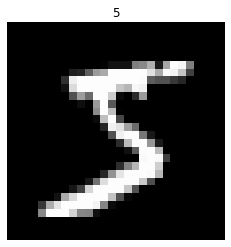

In [93]:
#Visualising the data
#understanding input and output shape
image, label = train_data[0]
print(f"Image Shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label);
plt.axis(False);

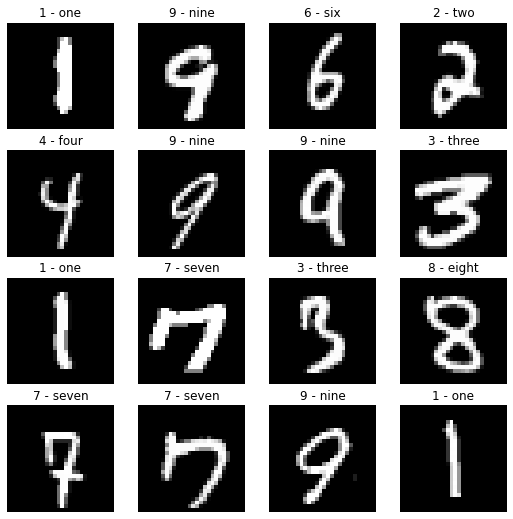

In [94]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [95]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 128
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [96]:
model_LENET_0 = LeNET().to(device)

In [97]:
def print_train_time(start:float,
                     end:float,
                     device:torch.device=None):
  total_time = end-start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

In [98]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_0.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [99]:
#Functionizing training and evaluation/testing loops
#We create a function for training loop - train_step()
#testing loop - test_step()

def train_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  train_loss, train_acc = 0, 0
  #Put model in training mode
  model.train()
  #Add a loop through the training batches 
  for batch, (X,y) in enumerate(data_loader):#Enumerate helps keeping track of batches
    #Put data on target device
    X,y = X.to(device), y.to(device)
    #forward pass
    y_pred = model(X)
    #loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    #Optimizer zero grad
    optimizer.zero_grad()
    #Loss backward
    loss.backward()
    #Step
    optimizer.step()

  #Adjust the training loss so that it gives us the loss per epoch an not per batch
  #Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.5f}, Train acc: {train_acc:.2f}%")

In [100]:
def test_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  test_loss, test_acc = 0, 0
  #Put model in training mode
  model.eval()
  #Add a loop through the training batches 
  with torch.inference_mode():
    for X,y in data_loader:#Enumerate helps keeping track of batches
      #Put data on target device
      X,y = X.to(device), y.to(device)
      #forward pass
      test_pred = model(X)
      #loss and accuracy
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    #Adjust the training loss so that it gives us the loss per epoch an not per batch
    #Divide total train loss by length of train dataloader
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [101]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_0, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_0,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----


  2%|▏         | 1/50 [00:01<00:54,  1.11s/it]

Train Loss: 2.30447, Train acc: 10.62%
Test Loss: 2.30225, Test acc: 11.66%
Epoch: 1 ----


  4%|▍         | 2/50 [00:02<00:53,  1.11s/it]

Train Loss: 2.30169, Train acc: 11.35%
Test Loss: 2.30079, Test acc: 11.66%
Epoch: 2 ----


  6%|▌         | 3/50 [00:03<00:53,  1.13s/it]

Train Loss: 2.29982, Train acc: 11.49%
Test Loss: 2.29946, Test acc: 11.66%
Epoch: 3 ----


  8%|▊         | 4/50 [00:04<00:51,  1.12s/it]

Train Loss: 2.29821, Train acc: 11.42%
Test Loss: 2.29801, Test acc: 11.66%
Epoch: 4 ----


 10%|█         | 5/50 [00:05<00:50,  1.11s/it]

Train Loss: 2.29622, Train acc: 11.15%
Test Loss: 2.29521, Test acc: 11.66%
Epoch: 5 ----


 12%|█▏        | 6/50 [00:06<00:48,  1.11s/it]

Train Loss: 2.29125, Train acc: 11.96%
Test Loss: 2.28870, Test acc: 12.96%
Epoch: 6 ----


 14%|█▍        | 7/50 [00:07<00:47,  1.10s/it]

Train Loss: 2.27864, Train acc: 21.74%
Test Loss: 2.27026, Test acc: 23.55%
Epoch: 7 ----


 16%|█▌        | 8/50 [00:08<00:46,  1.10s/it]

Train Loss: 2.22713, Train acc: 41.19%
Test Loss: 2.16135, Test acc: 41.95%
Epoch: 8 ----


 18%|█▊        | 9/50 [00:09<00:45,  1.10s/it]

Train Loss: 1.63844, Train acc: 57.59%
Test Loss: 1.44989, Test acc: 53.23%
Epoch: 9 ----


 20%|██        | 10/50 [00:11<00:43,  1.09s/it]

Train Loss: 0.76597, Train acc: 75.72%
Test Loss: 0.99427, Test acc: 66.34%
Epoch: 10 ----


 22%|██▏       | 11/50 [00:12<00:42,  1.09s/it]

Train Loss: 0.56964, Train acc: 82.21%
Test Loss: 0.90616, Test acc: 69.46%
Epoch: 11 ----


 24%|██▍       | 12/50 [00:13<00:41,  1.09s/it]

Train Loss: 0.47379, Train acc: 85.54%
Test Loss: 0.71709, Test acc: 76.72%
Epoch: 12 ----


 26%|██▌       | 13/50 [00:14<00:40,  1.08s/it]

Train Loss: 0.42121, Train acc: 87.09%
Test Loss: 0.70590, Test acc: 79.13%
Epoch: 13 ----


 28%|██▊       | 14/50 [00:15<00:38,  1.08s/it]

Train Loss: 0.37722, Train acc: 88.70%
Test Loss: 0.44363, Test acc: 86.98%
Epoch: 14 ----


 30%|███       | 15/50 [00:16<00:38,  1.10s/it]

Train Loss: 0.34100, Train acc: 89.75%
Test Loss: 0.50187, Test acc: 83.06%
Epoch: 15 ----


 32%|███▏      | 16/50 [00:17<00:37,  1.11s/it]

Train Loss: 0.31330, Train acc: 90.36%
Test Loss: 0.66623, Test acc: 79.15%
Epoch: 16 ----


 34%|███▍      | 17/50 [00:18<00:36,  1.10s/it]

Train Loss: 0.29062, Train acc: 91.15%
Test Loss: 0.80480, Test acc: 74.00%
Epoch: 17 ----


 36%|███▌      | 18/50 [00:19<00:35,  1.10s/it]

Train Loss: 0.27140, Train acc: 91.74%
Test Loss: 0.36746, Test acc: 89.10%
Epoch: 18 ----


 38%|███▊      | 19/50 [00:20<00:33,  1.10s/it]

Train Loss: 0.24894, Train acc: 92.43%
Test Loss: 1.62109, Test acc: 62.09%
Epoch: 19 ----


 40%|████      | 20/50 [00:21<00:32,  1.10s/it]

Train Loss: 0.25248, Train acc: 92.48%
Test Loss: 0.47632, Test acc: 86.04%
Epoch: 20 ----


 42%|████▏     | 21/50 [00:23<00:31,  1.10s/it]

Train Loss: 0.22931, Train acc: 93.17%
Test Loss: 1.43236, Test acc: 67.06%
Epoch: 21 ----


 44%|████▍     | 22/50 [00:24<00:30,  1.10s/it]

Train Loss: 0.23487, Train acc: 93.22%
Test Loss: 0.54083, Test acc: 83.47%
Epoch: 22 ----


 46%|████▌     | 23/50 [00:25<00:29,  1.10s/it]

Train Loss: 0.20654, Train acc: 93.63%
Test Loss: 0.31385, Test acc: 90.37%
Epoch: 23 ----


 48%|████▊     | 24/50 [00:26<00:28,  1.10s/it]

Train Loss: 0.19054, Train acc: 94.12%
Test Loss: 0.44614, Test acc: 85.51%
Epoch: 24 ----


 50%|█████     | 25/50 [00:27<00:27,  1.11s/it]

Train Loss: 0.18273, Train acc: 94.48%
Test Loss: 0.43288, Test acc: 86.01%
Epoch: 25 ----


 52%|█████▏    | 26/50 [00:28<00:26,  1.10s/it]

Train Loss: 0.17530, Train acc: 94.63%
Test Loss: 0.48085, Test acc: 85.01%
Epoch: 26 ----


 54%|█████▍    | 27/50 [00:29<00:25,  1.11s/it]

Train Loss: 0.18485, Train acc: 94.32%
Test Loss: 0.22818, Test acc: 92.52%
Epoch: 27 ----


 56%|█████▌    | 28/50 [00:30<00:24,  1.10s/it]

Train Loss: 0.15946, Train acc: 95.17%
Test Loss: 0.26852, Test acc: 90.92%
Epoch: 28 ----


 58%|█████▊    | 29/50 [00:31<00:22,  1.09s/it]

Train Loss: 0.15883, Train acc: 94.96%
Test Loss: 0.21287, Test acc: 93.62%
Epoch: 29 ----


 60%|██████    | 30/50 [00:32<00:21,  1.09s/it]

Train Loss: 0.14971, Train acc: 95.51%
Test Loss: 0.29211, Test acc: 89.89%
Epoch: 30 ----


 62%|██████▏   | 31/50 [00:34<00:20,  1.09s/it]

Train Loss: 0.14474, Train acc: 95.28%
Test Loss: 0.20912, Test acc: 93.51%
Epoch: 31 ----


 64%|██████▍   | 32/50 [00:35<00:19,  1.08s/it]

Train Loss: 0.13875, Train acc: 95.73%
Test Loss: 0.48692, Test acc: 83.46%
Epoch: 32 ----


 66%|██████▌   | 33/50 [00:36<00:18,  1.08s/it]

Train Loss: 0.13636, Train acc: 95.78%
Test Loss: 0.21068, Test acc: 93.65%
Epoch: 33 ----


 68%|██████▊   | 34/50 [00:37<00:17,  1.09s/it]

Train Loss: 0.13695, Train acc: 95.68%
Test Loss: 0.92883, Test acc: 75.80%
Epoch: 34 ----


 70%|███████   | 35/50 [00:38<00:16,  1.09s/it]

Train Loss: 0.13954, Train acc: 95.65%
Test Loss: 0.33832, Test acc: 89.50%
Epoch: 35 ----


 72%|███████▏  | 36/50 [00:39<00:15,  1.09s/it]

Train Loss: 0.12113, Train acc: 96.20%
Test Loss: 0.19004, Test acc: 94.39%
Epoch: 36 ----


 74%|███████▍  | 37/50 [00:40<00:14,  1.09s/it]

Train Loss: 0.11712, Train acc: 96.15%
Test Loss: 0.22478, Test acc: 93.04%
Epoch: 37 ----


 76%|███████▌  | 38/50 [00:41<00:13,  1.09s/it]

Train Loss: 0.11570, Train acc: 96.33%
Test Loss: 0.87778, Test acc: 72.87%
Epoch: 38 ----


 78%|███████▊  | 39/50 [00:42<00:11,  1.09s/it]

Train Loss: 0.12184, Train acc: 96.37%
Test Loss: 0.17702, Test acc: 94.43%
Epoch: 39 ----


 80%|████████  | 40/50 [00:43<00:10,  1.09s/it]

Train Loss: 0.10431, Train acc: 96.57%
Test Loss: 0.53730, Test acc: 84.78%
Epoch: 40 ----


 82%|████████▏ | 41/50 [00:44<00:09,  1.09s/it]

Train Loss: 0.10755, Train acc: 96.63%
Test Loss: 0.20619, Test acc: 93.12%
Epoch: 41 ----


 84%|████████▍ | 42/50 [00:45<00:08,  1.09s/it]

Train Loss: 0.09574, Train acc: 96.97%
Test Loss: 0.18391, Test acc: 94.61%
Epoch: 42 ----


 86%|████████▌ | 43/50 [00:47<00:07,  1.08s/it]

Train Loss: 0.09219, Train acc: 97.16%
Test Loss: 0.16471, Test acc: 95.05%
Epoch: 43 ----


 88%|████████▊ | 44/50 [00:48<00:06,  1.10s/it]

Train Loss: 0.08645, Train acc: 97.14%
Test Loss: 0.16405, Test acc: 94.76%
Epoch: 44 ----


 90%|█████████ | 45/50 [00:49<00:05,  1.10s/it]

Train Loss: 0.08386, Train acc: 97.44%
Test Loss: 0.17515, Test acc: 94.29%
Epoch: 45 ----


 92%|█████████▏| 46/50 [00:50<00:04,  1.10s/it]

Train Loss: 0.07949, Train acc: 97.53%
Test Loss: 0.17316, Test acc: 94.58%
Epoch: 46 ----


 94%|█████████▍| 47/50 [00:51<00:03,  1.10s/it]

Train Loss: 0.08330, Train acc: 97.34%
Test Loss: 0.25828, Test acc: 91.80%
Epoch: 47 ----


 96%|█████████▌| 48/50 [00:52<00:02,  1.10s/it]

Train Loss: 0.07859, Train acc: 97.41%
Test Loss: 0.19820, Test acc: 93.36%
Epoch: 48 ----


 98%|█████████▊| 49/50 [00:53<00:01,  1.09s/it]

Train Loss: 0.07642, Train acc: 97.54%
Test Loss: 0.77191, Test acc: 81.99%
Epoch: 49 ----


100%|██████████| 50/50 [00:54<00:00,  1.10s/it]

Train Loss: 0.09235, Train acc: 97.48%
Test Loss: 0.15529, Test acc: 95.02%
Train time on cuda : 54.764 seconds


In [102]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "01_LENET_MNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [103]:
#Saving the model
torch.save(obj=model_LENET_0.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/01_LENET_MNIST.pth


In [104]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_MNIST = LeNET().to(device)
model_LENET_MNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [105]:
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device=device):
  loss,acc = 0, 0
  #Returns a dictionary containing the results of the model predicting on data_loader
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X,y = X.to(device), y.to(device)
      #Make predictions
      y_pred = model(X)

      #Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))
    #Scale the loss and acc to find the average loss and acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

In [106]:
#Get model results
model_LENET_MNIST_results = eval_model(
    model=model_LENET_MNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_MNIST_results

100%|██████████| 16/16 [00:00<00:00, 103.71it/s]


{'model_name': 'LeNET',
 'model_loss': 0.15529167652130127,
 'model_acc': 95.01953125}

Fashion MNIST


In [107]:
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.ToTensor())

test_data = datasets.FashionMNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.ToTensor())

In [108]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

({'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9},
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

In [109]:
import torch.utils.data as data_utils

indices_train = torch.arange(10000)
indices_test = torch.arange(2000)
train_data = data_utils.Subset(train_data, indices_train)
test_data = data_utils.Subset(test_data, indices_test)
len(train_data), len(test_data)

(10000, 2000)

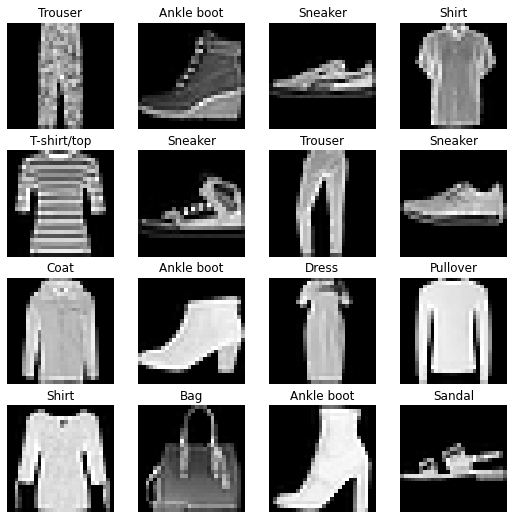

In [110]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [111]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [112]:
model_LENET_1 = LeNET().to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [113]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_1.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [114]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_1, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_1,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----


  2%|▏         | 1/50 [00:01<01:19,  1.63s/it]

Train Loss: 2.29743, Train acc: 12.64%
Test Loss: 2.26617, Test acc: 19.49%
Epoch: 1 ----


  4%|▍         | 2/50 [00:03<01:17,  1.62s/it]

Train Loss: 1.38855, Train acc: 48.02%
Test Loss: 1.04608, Test acc: 57.14%
Epoch: 2 ----
Train Loss: 0.86782, Train acc: 66.57%


  6%|▌         | 3/50 [00:04<01:16,  1.62s/it]

Test Loss: 0.84406, Test acc: 69.20%
Epoch: 3 ----


  8%|▊         | 4/50 [00:06<01:14,  1.63s/it]

Train Loss: 0.73885, Train acc: 71.48%
Test Loss: 0.74874, Test acc: 71.13%
Epoch: 4 ----


 10%|█         | 5/50 [00:08<01:13,  1.64s/it]

Train Loss: 0.67625, Train acc: 73.35%
Test Loss: 0.68507, Test acc: 73.41%
Epoch: 5 ----


 12%|█▏        | 6/50 [00:09<01:11,  1.63s/it]

Train Loss: 0.62769, Train acc: 75.55%
Test Loss: 0.62912, Test acc: 75.69%
Epoch: 6 ----


 14%|█▍        | 7/50 [00:11<01:09,  1.62s/it]

Train Loss: 0.58597, Train acc: 77.42%
Test Loss: 0.69486, Test acc: 71.92%
Epoch: 7 ----


 16%|█▌        | 8/50 [00:13<01:08,  1.62s/it]

Train Loss: 0.56304, Train acc: 78.72%
Test Loss: 0.67398, Test acc: 76.09%


 18%|█▊        | 9/50 [00:14<01:06,  1.62s/it]

Epoch: 8 ----
Train Loss: 0.53578, Train acc: 79.84%
Test Loss: 0.54754, Test acc: 79.91%
Epoch: 9 ----


 20%|██        | 10/50 [00:16<01:04,  1.62s/it]

Train Loss: 0.51644, Train acc: 80.06%
Test Loss: 0.57861, Test acc: 78.42%
Epoch: 10 ----


 22%|██▏       | 11/50 [00:17<01:03,  1.62s/it]

Train Loss: 0.49582, Train acc: 81.29%
Test Loss: 0.60003, Test acc: 78.77%
Epoch: 11 ----


 24%|██▍       | 12/50 [00:19<01:01,  1.62s/it]

Train Loss: 0.47856, Train acc: 81.79%
Test Loss: 0.51620, Test acc: 81.65%
Epoch: 12 ----


 26%|██▌       | 13/50 [00:21<00:59,  1.62s/it]

Train Loss: 0.46031, Train acc: 82.60%
Test Loss: 0.50562, Test acc: 81.65%
Epoch: 13 ----


 28%|██▊       | 14/50 [00:22<00:58,  1.62s/it]

Train Loss: 0.45122, Train acc: 83.15%
Test Loss: 0.58118, Test acc: 77.98%
Epoch: 14 ----


 30%|███       | 15/50 [00:24<00:56,  1.62s/it]

Train Loss: 0.43702, Train acc: 83.76%
Test Loss: 0.48377, Test acc: 82.29%
Epoch: 15 ----


 32%|███▏      | 16/50 [00:26<00:55,  1.64s/it]

Train Loss: 0.42325, Train acc: 84.09%
Test Loss: 0.51908, Test acc: 80.11%
Epoch: 16 ----


 34%|███▍      | 17/50 [00:27<00:54,  1.64s/it]

Train Loss: 0.41326, Train acc: 84.40%
Test Loss: 0.52592, Test acc: 80.41%
Epoch: 17 ----


 36%|███▌      | 18/50 [00:29<00:52,  1.63s/it]

Train Loss: 0.40710, Train acc: 84.67%
Test Loss: 0.45242, Test acc: 83.23%
Epoch: 18 ----
Train Loss: 0.39630, Train acc: 85.25%


 38%|███▊      | 19/50 [00:30<00:50,  1.64s/it]

Test Loss: 0.46057, Test acc: 83.68%
Epoch: 19 ----


 40%|████      | 20/50 [00:32<00:49,  1.63s/it]

Train Loss: 0.38435, Train acc: 85.71%
Test Loss: 0.44772, Test acc: 84.18%
Epoch: 20 ----


 42%|████▏     | 21/50 [00:34<00:47,  1.63s/it]

Train Loss: 0.38423, Train acc: 85.64%
Test Loss: 0.48733, Test acc: 82.04%
Epoch: 21 ----


 44%|████▍     | 22/50 [00:35<00:45,  1.63s/it]

Train Loss: 0.36802, Train acc: 85.97%
Test Loss: 0.48567, Test acc: 82.09%
Epoch: 22 ----


 46%|████▌     | 23/50 [00:37<00:43,  1.63s/it]

Train Loss: 0.36364, Train acc: 86.07%
Test Loss: 0.51676, Test acc: 80.36%
Epoch: 23 ----


 48%|████▊     | 24/50 [00:39<00:42,  1.62s/it]

Train Loss: 0.35237, Train acc: 86.34%
Test Loss: 0.43714, Test acc: 84.82%
Epoch: 24 ----


 50%|█████     | 25/50 [00:40<00:40,  1.62s/it]

Train Loss: 0.34543, Train acc: 86.77%
Test Loss: 0.59320, Test acc: 80.11%
Epoch: 25 ----


 52%|█████▏    | 26/50 [00:42<00:38,  1.62s/it]

Train Loss: 0.34223, Train acc: 86.96%
Test Loss: 0.43225, Test acc: 84.67%
Epoch: 26 ----


 54%|█████▍    | 27/50 [00:43<00:37,  1.63s/it]

Train Loss: 0.33426, Train acc: 87.26%
Test Loss: 0.41075, Test acc: 85.91%
Epoch: 27 ----


 56%|█████▌    | 28/50 [00:45<00:35,  1.62s/it]

Train Loss: 0.32941, Train acc: 87.58%
Test Loss: 0.41495, Test acc: 84.52%
Epoch: 28 ----


 58%|█████▊    | 29/50 [00:47<00:34,  1.63s/it]

Train Loss: 0.32088, Train acc: 87.71%
Test Loss: 0.43277, Test acc: 84.57%
Epoch: 29 ----


 60%|██████    | 30/50 [00:48<00:32,  1.62s/it]

Train Loss: 0.31137, Train acc: 88.28%
Test Loss: 0.43303, Test acc: 85.22%
Epoch: 30 ----


 62%|██████▏   | 31/50 [00:50<00:30,  1.62s/it]

Train Loss: 0.31154, Train acc: 88.15%
Test Loss: 0.43206, Test acc: 84.97%
Epoch: 31 ----


 64%|██████▍   | 32/50 [00:52<00:29,  1.62s/it]

Train Loss: 0.30105, Train acc: 88.40%
Test Loss: 0.44440, Test acc: 83.83%
Epoch: 32 ----


 66%|██████▌   | 33/50 [00:53<00:27,  1.62s/it]

Train Loss: 0.29687, Train acc: 88.59%
Test Loss: 0.43584, Test acc: 84.92%
Epoch: 33 ----


 68%|██████▊   | 34/50 [00:55<00:26,  1.63s/it]

Train Loss: 0.29069, Train acc: 89.35%
Test Loss: 0.50505, Test acc: 83.28%


 70%|███████   | 35/50 [00:56<00:24,  1.63s/it]

Epoch: 34 ----
Train Loss: 0.28938, Train acc: 88.80%
Test Loss: 0.41452, Test acc: 85.76%


 72%|███████▏  | 36/50 [00:58<00:22,  1.62s/it]

Epoch: 35 ----
Train Loss: 0.28844, Train acc: 89.12%
Test Loss: 0.55842, Test acc: 79.81%
Epoch: 36 ----


 74%|███████▍  | 37/50 [01:00<00:21,  1.62s/it]

Train Loss: 0.27727, Train acc: 89.63%
Test Loss: 0.43858, Test acc: 84.97%
Epoch: 37 ----


 76%|███████▌  | 38/50 [01:01<00:19,  1.62s/it]

Train Loss: 0.26824, Train acc: 89.40%
Test Loss: 0.43250, Test acc: 85.71%
Epoch: 38 ----


 78%|███████▊  | 39/50 [01:03<00:17,  1.61s/it]

Train Loss: 0.26326, Train acc: 89.80%
Test Loss: 0.44392, Test acc: 85.37%
Epoch: 39 ----


 80%|████████  | 40/50 [01:04<00:16,  1.61s/it]

Train Loss: 0.25898, Train acc: 90.00%
Test Loss: 0.51660, Test acc: 83.33%
Epoch: 40 ----


 82%|████████▏ | 41/50 [01:06<00:14,  1.63s/it]

Train Loss: 0.25723, Train acc: 89.94%
Test Loss: 0.47493, Test acc: 84.38%
Epoch: 41 ----


 84%|████████▍ | 42/50 [01:08<00:13,  1.63s/it]

Train Loss: 0.25365, Train acc: 90.40%
Test Loss: 0.46760, Test acc: 84.92%
Epoch: 42 ----


 86%|████████▌ | 43/50 [01:09<00:11,  1.63s/it]

Train Loss: 0.24605, Train acc: 90.59%
Test Loss: 0.46868, Test acc: 85.07%
Epoch: 43 ----


 88%|████████▊ | 44/50 [01:11<00:09,  1.63s/it]

Train Loss: 0.23964, Train acc: 90.95%
Test Loss: 0.47737, Test acc: 84.77%
Epoch: 44 ----
Train Loss: 0.24459, Train acc: 90.69%


 90%|█████████ | 45/50 [01:13<00:08,  1.63s/it]

Test Loss: 0.45955, Test acc: 85.81%
Epoch: 45 ----


 92%|█████████▏| 46/50 [01:14<00:06,  1.62s/it]

Train Loss: 0.23289, Train acc: 91.12%
Test Loss: 0.45307, Test acc: 85.86%
Epoch: 46 ----


 94%|█████████▍| 47/50 [01:16<00:04,  1.62s/it]

Train Loss: 0.22851, Train acc: 91.19%
Test Loss: 0.44885, Test acc: 85.91%
Epoch: 47 ----


 96%|█████████▌| 48/50 [01:17<00:03,  1.61s/it]

Train Loss: 0.22512, Train acc: 91.19%
Test Loss: 0.47201, Test acc: 84.77%
Epoch: 48 ----


 98%|█████████▊| 49/50 [01:19<00:01,  1.61s/it]

Train Loss: 0.22300, Train acc: 91.55%
Test Loss: 0.47259, Test acc: 84.38%
Epoch: 49 ----


100%|██████████| 50/50 [01:21<00:00,  1.62s/it]

Train Loss: 0.21799, Train acc: 91.68%
Test Loss: 0.47222, Test acc: 84.97%
Train time on cuda : 81.197 seconds


In [115]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "02_LENET_FashionMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [116]:
#Saving the model
torch.save(obj=model_LENET_1.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/02_LENET_FashionMNIST.pth


In [117]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_FashionMNIST = LeNET().to(device)
model_LENET_FashionMNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [118]:
#Get model results
model_LENET_FashionMNIST_results = eval_model(
    model=model_LENET_FashionMNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_FashionMNIST_results

100%|██████████| 63/63 [00:00<00:00, 321.77it/s]


{'model_name': 'LeNET',
 'model_loss': 0.47221800684928894,
 'model_acc': 84.9702380952381}

CIFAR 10


In [119]:
train_data = datasets.CIFAR10(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

test_data = datasets.CIFAR10(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [120]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

({'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9},
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

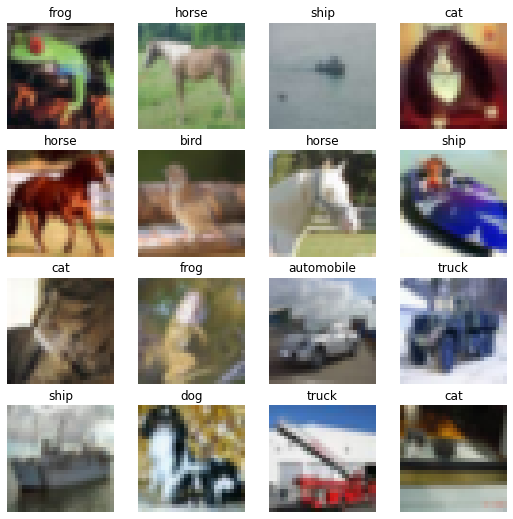

In [121]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))#(c,h,w) moves channel to the back in accordance to the matplotlib format
  plt.title(class_names[label])
  plt.axis(False)

In [122]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [123]:
model_LENET_2 = LeNET(in_channels=3).to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [124]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_2.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [125]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=100

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_2, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_2,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 2.30279, Train acc: 9.93%


  1%|          | 1/100 [00:12<20:00, 12.13s/it]

Test Loss: 2.30010, Test acc: 13.96%
Epoch: 1 ----
Train Loss: 2.05689, Train acc: 23.80%


  2%|▏         | 2/100 [00:24<19:39, 12.04s/it]

Test Loss: 1.84966, Test acc: 33.55%
Epoch: 2 ----
Train Loss: 1.75797, Train acc: 37.01%


  3%|▎         | 3/100 [00:36<19:24, 12.00s/it]

Test Loss: 1.63985, Test acc: 40.38%
Epoch: 3 ----
Train Loss: 1.59679, Train acc: 42.77%


  4%|▍         | 4/100 [00:48<19:13, 12.01s/it]

Test Loss: 1.59023, Test acc: 42.80%
Epoch: 4 ----
Train Loss: 1.49755, Train acc: 46.36%


  5%|▌         | 5/100 [01:00<19:02, 12.02s/it]

Test Loss: 1.58012, Test acc: 44.76%
Epoch: 5 ----
Train Loss: 1.43134, Train acc: 48.90%


  6%|▌         | 6/100 [01:12<18:51, 12.04s/it]

Test Loss: 1.40498, Test acc: 49.52%
Epoch: 6 ----
Train Loss: 1.36891, Train acc: 51.47%


  7%|▋         | 7/100 [01:24<18:41, 12.06s/it]

Test Loss: 1.39107, Test acc: 50.39%
Epoch: 7 ----
Train Loss: 1.31526, Train acc: 52.96%


  8%|▊         | 8/100 [01:36<18:26, 12.03s/it]

Test Loss: 1.35375, Test acc: 51.63%
Epoch: 8 ----
Train Loss: 1.26901, Train acc: 54.83%


  9%|▉         | 9/100 [01:48<18:14, 12.03s/it]

Test Loss: 1.37695, Test acc: 50.98%
Epoch: 9 ----
Train Loss: 1.22594, Train acc: 56.27%


 10%|█         | 10/100 [02:00<18:00, 12.01s/it]

Test Loss: 1.25745, Test acc: 55.92%
Epoch: 10 ----
Train Loss: 1.18631, Train acc: 57.74%


 11%|█         | 11/100 [02:12<17:52, 12.06s/it]

Test Loss: 1.25066, Test acc: 56.22%
Epoch: 11 ----
Train Loss: 1.14819, Train acc: 59.19%


 12%|█▏        | 12/100 [02:24<17:41, 12.06s/it]

Test Loss: 1.24303, Test acc: 56.62%
Epoch: 12 ----
Train Loss: 1.11562, Train acc: 60.51%


 13%|█▎        | 13/100 [02:36<17:26, 12.03s/it]

Test Loss: 1.22630, Test acc: 56.95%
Epoch: 13 ----
Train Loss: 1.08263, Train acc: 61.44%


 14%|█▍        | 14/100 [02:48<17:13, 12.02s/it]

Test Loss: 1.35431, Test acc: 53.55%
Epoch: 14 ----
Train Loss: 1.05016, Train acc: 62.84%


 15%|█▌        | 15/100 [03:00<17:01, 12.02s/it]

Test Loss: 1.19875, Test acc: 58.82%
Epoch: 15 ----
Train Loss: 1.01950, Train acc: 63.63%


 16%|█▌        | 16/100 [03:12<16:51, 12.04s/it]

Test Loss: 1.22113, Test acc: 57.91%
Epoch: 16 ----
Train Loss: 0.99476, Train acc: 64.65%


 17%|█▋        | 17/100 [03:24<16:38, 12.03s/it]

Test Loss: 1.22669, Test acc: 56.91%
Epoch: 17 ----
Train Loss: 0.96933, Train acc: 65.72%


 18%|█▊        | 18/100 [03:36<16:27, 12.04s/it]

Test Loss: 1.22634, Test acc: 58.09%
Epoch: 18 ----
Train Loss: 0.94630, Train acc: 66.39%


 19%|█▉        | 19/100 [03:48<16:13, 12.02s/it]

Test Loss: 1.41001, Test acc: 54.30%
Epoch: 19 ----
Train Loss: 0.92004, Train acc: 67.33%


 20%|██        | 20/100 [04:00<15:59, 12.00s/it]

Test Loss: 1.34782, Test acc: 53.91%
Epoch: 20 ----
Train Loss: 0.89867, Train acc: 68.13%


 21%|██        | 21/100 [04:12<15:48, 12.01s/it]

Test Loss: 1.23464, Test acc: 57.91%
Epoch: 21 ----
Train Loss: 0.87619, Train acc: 68.93%


 22%|██▏       | 22/100 [04:24<15:38, 12.04s/it]

Test Loss: 1.21320, Test acc: 59.10%
Epoch: 22 ----
Train Loss: 0.85558, Train acc: 69.52%


 23%|██▎       | 23/100 [04:36<15:23, 12.00s/it]

Test Loss: 1.26251, Test acc: 58.62%
Epoch: 23 ----
Train Loss: 0.83148, Train acc: 70.61%


 24%|██▍       | 24/100 [04:48<15:12, 12.01s/it]

Test Loss: 1.27400, Test acc: 57.89%
Epoch: 24 ----
Train Loss: 0.81684, Train acc: 70.96%


 25%|██▌       | 25/100 [05:00<15:01, 12.03s/it]

Test Loss: 1.26943, Test acc: 59.33%
Epoch: 25 ----
Train Loss: 0.80100, Train acc: 71.47%


 26%|██▌       | 26/100 [05:12<14:48, 12.01s/it]

Test Loss: 1.29198, Test acc: 58.77%
Epoch: 26 ----
Train Loss: 0.78215, Train acc: 72.09%


 27%|██▋       | 27/100 [05:24<14:37, 12.03s/it]

Test Loss: 1.28847, Test acc: 58.88%
Epoch: 27 ----
Train Loss: 0.76455, Train acc: 72.80%


 28%|██▊       | 28/100 [05:36<14:23, 12.00s/it]

Test Loss: 1.32022, Test acc: 58.51%
Epoch: 28 ----
Train Loss: 0.74826, Train acc: 73.18%


 29%|██▉       | 29/100 [05:48<14:11, 11.99s/it]

Test Loss: 1.35408, Test acc: 57.97%
Epoch: 29 ----
Train Loss: 0.73342, Train acc: 73.76%


 30%|███       | 30/100 [06:00<13:59, 11.99s/it]

Test Loss: 1.38805, Test acc: 58.13%
Epoch: 30 ----
Train Loss: 0.71482, Train acc: 74.44%


 31%|███       | 31/100 [06:12<13:47, 11.99s/it]

Test Loss: 1.42816, Test acc: 57.09%
Epoch: 31 ----
Train Loss: 0.70582, Train acc: 74.67%


 32%|███▏      | 32/100 [06:24<13:37, 12.03s/it]

Test Loss: 1.35036, Test acc: 58.39%
Epoch: 32 ----
Train Loss: 0.69066, Train acc: 74.92%


 33%|███▎      | 33/100 [06:36<13:23, 12.00s/it]

Test Loss: 1.37132, Test acc: 58.75%
Epoch: 33 ----
Train Loss: 0.67303, Train acc: 75.72%


 34%|███▍      | 34/100 [06:48<13:09, 11.97s/it]

Test Loss: 1.45357, Test acc: 57.33%
Epoch: 34 ----
Train Loss: 0.66436, Train acc: 76.00%


 35%|███▌      | 35/100 [07:00<12:57, 11.96s/it]

Test Loss: 1.40993, Test acc: 58.35%
Epoch: 35 ----
Train Loss: 0.65105, Train acc: 76.54%


 36%|███▌      | 36/100 [07:12<12:45, 11.96s/it]

Test Loss: 1.42966, Test acc: 57.62%
Epoch: 36 ----
Train Loss: 0.63485, Train acc: 77.13%


 37%|███▋      | 37/100 [07:24<12:35, 11.99s/it]

Test Loss: 1.51219, Test acc: 57.32%
Epoch: 37 ----
Train Loss: 0.62739, Train acc: 77.20%


 38%|███▊      | 38/100 [07:36<12:24, 12.00s/it]

Test Loss: 1.56150, Test acc: 55.88%
Epoch: 38 ----
Train Loss: 0.62057, Train acc: 77.54%


 39%|███▉      | 39/100 [07:48<12:10, 11.98s/it]

Test Loss: 1.53243, Test acc: 57.40%
Epoch: 39 ----
Train Loss: 0.60281, Train acc: 78.30%


 40%|████      | 40/100 [08:00<11:59, 11.99s/it]

Test Loss: 1.62063, Test acc: 56.40%
Epoch: 40 ----
Train Loss: 0.59366, Train acc: 78.46%


 41%|████      | 41/100 [08:12<11:48, 12.01s/it]

Test Loss: 1.59947, Test acc: 57.66%
Epoch: 41 ----
Train Loss: 0.58506, Train acc: 78.83%


 42%|████▏     | 42/100 [08:24<11:38, 12.05s/it]

Test Loss: 1.56526, Test acc: 58.91%
Epoch: 42 ----
Train Loss: 0.57297, Train acc: 79.10%


 43%|████▎     | 43/100 [08:36<11:27, 12.06s/it]

Test Loss: 1.71260, Test acc: 55.45%
Epoch: 43 ----
Train Loss: 0.56484, Train acc: 79.53%


 44%|████▍     | 44/100 [08:48<11:13, 12.03s/it]

Test Loss: 1.60182, Test acc: 58.01%
Epoch: 44 ----
Train Loss: 0.54991, Train acc: 80.20%


 45%|████▌     | 45/100 [09:00<11:02, 12.05s/it]

Test Loss: 1.60930, Test acc: 58.09%
Epoch: 45 ----
Train Loss: 0.54351, Train acc: 80.20%


 46%|████▌     | 46/100 [09:12<10:48, 12.02s/it]

Test Loss: 1.75336, Test acc: 56.53%
Epoch: 46 ----
Train Loss: 0.54025, Train acc: 80.38%


 47%|████▋     | 47/100 [09:24<10:39, 12.06s/it]

Test Loss: 1.68318, Test acc: 57.91%
Epoch: 47 ----
Train Loss: 0.52752, Train acc: 80.82%


 48%|████▊     | 48/100 [09:36<10:25, 12.02s/it]

Test Loss: 1.73317, Test acc: 57.03%
Epoch: 48 ----
Train Loss: 0.52183, Train acc: 81.11%


 49%|████▉     | 49/100 [09:48<10:11, 12.00s/it]

Test Loss: 1.77313, Test acc: 57.28%
Epoch: 49 ----
Train Loss: 0.51039, Train acc: 81.40%


 50%|█████     | 50/100 [10:00<10:00, 12.01s/it]

Test Loss: 1.82593, Test acc: 57.24%
Epoch: 50 ----
Train Loss: 0.50593, Train acc: 81.67%


 51%|█████     | 51/100 [10:12<09:48, 12.01s/it]

Test Loss: 1.77290, Test acc: 56.56%
Epoch: 51 ----
Train Loss: 0.50138, Train acc: 81.64%


 52%|█████▏    | 52/100 [10:25<09:39, 12.07s/it]

Test Loss: 1.83902, Test acc: 56.83%
Epoch: 52 ----
Train Loss: 0.49168, Train acc: 81.91%


 53%|█████▎    | 53/100 [10:37<09:26, 12.06s/it]

Test Loss: 1.87906, Test acc: 56.54%
Epoch: 53 ----
Train Loss: 0.49007, Train acc: 82.36%


 54%|█████▍    | 54/100 [10:49<09:13, 12.03s/it]

Test Loss: 1.87830, Test acc: 57.19%
Epoch: 54 ----
Train Loss: 0.47694, Train acc: 82.73%


 55%|█████▌    | 55/100 [11:01<09:00, 12.01s/it]

Test Loss: 1.93239, Test acc: 56.54%
Epoch: 55 ----
Train Loss: 0.47770, Train acc: 82.70%


 56%|█████▌    | 56/100 [11:13<08:48, 12.01s/it]

Test Loss: 2.09090, Test acc: 55.77%
Epoch: 56 ----
Train Loss: 0.47767, Train acc: 82.85%


 57%|█████▋    | 57/100 [11:24<08:35, 11.99s/it]

Test Loss: 1.91532, Test acc: 56.19%
Epoch: 57 ----
Train Loss: 0.46000, Train acc: 83.21%


 58%|█████▊    | 58/100 [11:37<08:26, 12.05s/it]

Test Loss: 2.06157, Test acc: 55.01%
Epoch: 58 ----
Train Loss: 0.45498, Train acc: 83.43%


 59%|█████▉    | 59/100 [11:49<08:13, 12.03s/it]

Test Loss: 2.03782, Test acc: 56.65%
Epoch: 59 ----
Train Loss: 0.44510, Train acc: 83.88%


 60%|██████    | 60/100 [12:01<08:00, 12.01s/it]

Test Loss: 1.95453, Test acc: 57.10%
Epoch: 60 ----
Train Loss: 0.44656, Train acc: 83.91%


 61%|██████    | 61/100 [12:13<07:49, 12.04s/it]

Test Loss: 2.20648, Test acc: 53.90%
Epoch: 61 ----
Train Loss: 0.44403, Train acc: 83.82%


 62%|██████▏   | 62/100 [12:25<07:38, 12.07s/it]

Test Loss: 2.12449, Test acc: 55.59%
Epoch: 62 ----
Train Loss: 0.43740, Train acc: 83.90%


 63%|██████▎   | 63/100 [12:37<07:30, 12.17s/it]

Test Loss: 2.19839, Test acc: 55.80%
Epoch: 63 ----
Train Loss: 0.42779, Train acc: 84.32%


 64%|██████▍   | 64/100 [12:50<07:19, 12.20s/it]

Test Loss: 2.18584, Test acc: 56.63%
Epoch: 64 ----
Train Loss: 0.43469, Train acc: 84.34%


 65%|██████▌   | 65/100 [13:02<07:07, 12.23s/it]

Test Loss: 2.15417, Test acc: 56.27%
Epoch: 65 ----
Train Loss: 0.42800, Train acc: 84.35%


 66%|██████▌   | 66/100 [13:14<06:56, 12.26s/it]

Test Loss: 2.19086, Test acc: 56.11%
Epoch: 66 ----
Train Loss: 0.41503, Train acc: 84.91%


 67%|██████▋   | 67/100 [13:26<06:44, 12.26s/it]

Test Loss: 2.21983, Test acc: 56.11%
Epoch: 67 ----
Train Loss: 0.40536, Train acc: 85.38%


 68%|██████▊   | 68/100 [13:39<06:35, 12.35s/it]

Test Loss: 2.36316, Test acc: 55.39%
Epoch: 68 ----
Train Loss: 0.40910, Train acc: 85.21%


 69%|██████▉   | 69/100 [13:51<06:20, 12.28s/it]

Test Loss: 2.27622, Test acc: 55.57%
Epoch: 69 ----
Train Loss: 0.41163, Train acc: 85.25%


 70%|███████   | 70/100 [14:03<06:05, 12.19s/it]

Test Loss: 2.29499, Test acc: 56.64%
Epoch: 70 ----
Train Loss: 0.40923, Train acc: 85.15%


 71%|███████   | 71/100 [14:15<05:52, 12.16s/it]

Test Loss: 2.30147, Test acc: 56.44%
Epoch: 71 ----
Train Loss: 0.39592, Train acc: 85.58%


 72%|███████▏  | 72/100 [14:27<05:41, 12.18s/it]

Test Loss: 2.37345, Test acc: 55.40%
Epoch: 72 ----
Train Loss: 0.39316, Train acc: 85.77%


 73%|███████▎  | 73/100 [14:40<05:28, 12.16s/it]

Test Loss: 2.33996, Test acc: 56.11%
Epoch: 73 ----
Train Loss: 0.39270, Train acc: 85.83%


 74%|███████▍  | 74/100 [14:52<05:16, 12.16s/it]

Test Loss: 2.41957, Test acc: 55.88%
Epoch: 74 ----
Train Loss: 0.38795, Train acc: 86.00%


 75%|███████▌  | 75/100 [15:04<05:03, 12.13s/it]

Test Loss: 2.34869, Test acc: 56.36%
Epoch: 75 ----
Train Loss: 0.38024, Train acc: 86.10%


 76%|███████▌  | 76/100 [15:16<04:50, 12.08s/it]

Test Loss: 2.74752, Test acc: 50.94%
Epoch: 76 ----
Train Loss: 0.38804, Train acc: 86.08%


 77%|███████▋  | 77/100 [15:28<04:37, 12.06s/it]

Test Loss: 2.42909, Test acc: 56.02%
Epoch: 77 ----
Train Loss: 0.37943, Train acc: 86.23%


 78%|███████▊  | 78/100 [15:40<04:25, 12.09s/it]

Test Loss: 2.50636, Test acc: 54.48%
Epoch: 78 ----
Train Loss: 0.38286, Train acc: 86.19%


 79%|███████▉  | 79/100 [15:52<04:13, 12.07s/it]

Test Loss: 2.48074, Test acc: 55.35%
Epoch: 79 ----
Train Loss: 0.37761, Train acc: 86.46%


 80%|████████  | 80/100 [16:04<04:01, 12.07s/it]

Test Loss: 2.60478, Test acc: 53.74%
Epoch: 80 ----
Train Loss: 0.36506, Train acc: 86.76%


 81%|████████  | 81/100 [16:16<03:49, 12.06s/it]

Test Loss: 2.64504, Test acc: 54.85%
Epoch: 81 ----
Train Loss: 0.36297, Train acc: 86.80%


 82%|████████▏ | 82/100 [16:28<03:36, 12.02s/it]

Test Loss: 2.64582, Test acc: 55.12%
Epoch: 82 ----
Train Loss: 0.37633, Train acc: 86.48%


 83%|████████▎ | 83/100 [16:40<03:25, 12.10s/it]

Test Loss: 2.53085, Test acc: 55.90%
Epoch: 83 ----
Train Loss: 0.35643, Train acc: 87.35%


 84%|████████▍ | 84/100 [16:52<03:12, 12.06s/it]

Test Loss: 2.63625, Test acc: 55.93%
Epoch: 84 ----
Train Loss: 0.35761, Train acc: 87.06%


 85%|████████▌ | 85/100 [17:04<03:01, 12.07s/it]

Test Loss: 2.69188, Test acc: 55.16%
Epoch: 85 ----
Train Loss: 0.35572, Train acc: 87.28%


 86%|████████▌ | 86/100 [17:16<02:48, 12.02s/it]

Test Loss: 3.00401, Test acc: 53.28%
Epoch: 86 ----
Train Loss: 0.36696, Train acc: 86.78%


 87%|████████▋ | 87/100 [17:28<02:35, 11.98s/it]

Test Loss: 2.60833, Test acc: 55.26%
Epoch: 87 ----
Train Loss: 0.35634, Train acc: 87.19%


 88%|████████▊ | 88/100 [17:40<02:24, 12.02s/it]

Test Loss: 2.77829, Test acc: 54.46%
Epoch: 88 ----
Train Loss: 0.34414, Train acc: 87.58%


 89%|████████▉ | 89/100 [17:52<02:11, 11.98s/it]

Test Loss: 2.72731, Test acc: 55.18%
Epoch: 89 ----
Train Loss: 0.35088, Train acc: 87.33%


 90%|█████████ | 90/100 [18:04<01:59, 11.96s/it]

Test Loss: 2.72130, Test acc: 54.93%
Epoch: 90 ----
Train Loss: 0.35800, Train acc: 87.15%


 91%|█████████ | 91/100 [18:16<01:47, 11.97s/it]

Test Loss: 2.63730, Test acc: 55.46%
Epoch: 91 ----
Train Loss: 0.34725, Train acc: 87.61%


 92%|█████████▏| 92/100 [18:28<01:36, 12.03s/it]

Test Loss: 2.80300, Test acc: 55.15%
Epoch: 92 ----
Train Loss: 0.34235, Train acc: 87.66%


 93%|█████████▎| 93/100 [18:40<01:24, 12.06s/it]

Test Loss: 2.83839, Test acc: 54.87%
Epoch: 93 ----
Train Loss: 0.35660, Train acc: 87.19%


 94%|█████████▍| 94/100 [18:52<01:12, 12.05s/it]

Test Loss: 2.84283, Test acc: 55.18%
Epoch: 94 ----
Train Loss: 0.33994, Train acc: 87.88%


 95%|█████████▌| 95/100 [19:04<01:00, 12.00s/it]

Test Loss: 2.86392, Test acc: 55.23%
Epoch: 95 ----
Train Loss: 0.34533, Train acc: 87.66%


 96%|█████████▌| 96/100 [19:16<00:47, 12.00s/it]

Test Loss: 3.14111, Test acc: 53.71%
Epoch: 96 ----
Train Loss: 0.33832, Train acc: 88.05%


 97%|█████████▋| 97/100 [19:28<00:35, 12.00s/it]

Test Loss: 2.98332, Test acc: 54.87%
Epoch: 97 ----
Train Loss: 0.33737, Train acc: 87.91%


 98%|█████████▊| 98/100 [19:40<00:24, 12.03s/it]

Test Loss: 2.90898, Test acc: 55.07%
Epoch: 98 ----
Train Loss: 0.32626, Train acc: 88.47%


 99%|█████████▉| 99/100 [19:52<00:12, 12.05s/it]

Test Loss: 2.92968, Test acc: 54.23%
Epoch: 99 ----
Train Loss: 0.34472, Train acc: 87.87%


100%|██████████| 100/100 [20:04<00:00, 12.05s/it]

Test Loss: 2.93392, Test acc: 54.61%
Train time on cuda : 1204.836 seconds


In [126]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "03_LENET_CIFAR10pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [127]:
#Saving the model
torch.save(obj=model_LENET_2.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/03_LENET_CIFAR10pth


In [128]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_CIFAR10 = LeNET(in_channels=3).to(device)
model_LENET_CIFAR10.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [129]:
#Get model results
model_LENET_CIFAR10_results = eval_model(
    model=model_LENET_CIFAR10,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_CIFAR10_results

100%|██████████| 313/313 [00:01<00:00, 191.45it/s]


{'model_name': 'LeNET',
 'model_loss': 2.9339194297790527,
 'model_acc': 54.61261980830671}

CIFAR100

In [130]:
train_data = datasets.CIFAR100(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

test_data = datasets.CIFAR100(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [131]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

({'apple': 0,
  'aquarium_fish': 1,
  'baby': 2,
  'bear': 3,
  'beaver': 4,
  'bed': 5,
  'bee': 6,
  'beetle': 7,
  'bicycle': 8,
  'bottle': 9,
  'bowl': 10,
  'boy': 11,
  'bridge': 12,
  'bus': 13,
  'butterfly': 14,
  'camel': 15,
  'can': 16,
  'castle': 17,
  'caterpillar': 18,
  'cattle': 19,
  'chair': 20,
  'chimpanzee': 21,
  'clock': 22,
  'cloud': 23,
  'cockroach': 24,
  'couch': 25,
  'crab': 26,
  'crocodile': 27,
  'cup': 28,
  'dinosaur': 29,
  'dolphin': 30,
  'elephant': 31,
  'flatfish': 32,
  'forest': 33,
  'fox': 34,
  'girl': 35,
  'hamster': 36,
  'house': 37,
  'kangaroo': 38,
  'keyboard': 39,
  'lamp': 40,
  'lawn_mower': 41,
  'leopard': 42,
  'lion': 43,
  'lizard': 44,
  'lobster': 45,
  'man': 46,
  'maple_tree': 47,
  'motorcycle': 48,
  'mountain': 49,
  'mouse': 50,
  'mushroom': 51,
  'oak_tree': 52,
  'orange': 53,
  'orchid': 54,
  'otter': 55,
  'palm_tree': 56,
  'pear': 57,
  'pickup_truck': 58,
  'pine_tree': 59,
  'plain': 60,
  'plate': 61,

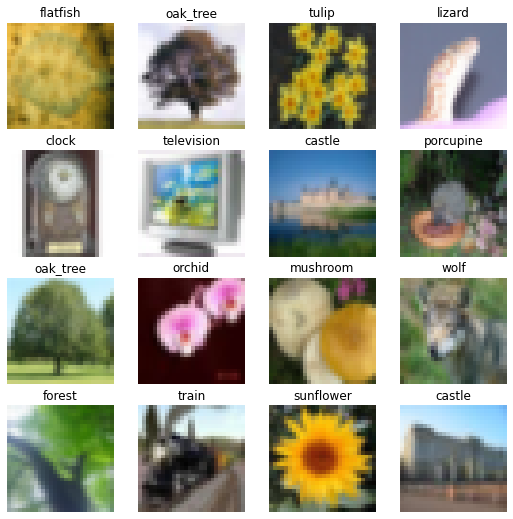

In [132]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))#(c,h,w) moves channel to the back in accordance to the matplotlib format
  plt.title(class_names[label])
  plt.axis(False)

In [140]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [141]:
model_LENET_3 = LeNET(in_channels=3, num_classes=100).to(device)
device

'cuda'

In [142]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_3.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [143]:
#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=100

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_3, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_3,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 4.57523, Train acc: 1.62%


  1%|          | 1/100 [00:12<20:09, 12.21s/it]

Test Loss: 4.42234, Test acc: 3.15%
Epoch: 1 ----
Train Loss: 4.11509, Train acc: 7.11%


  2%|▏         | 2/100 [00:24<19:38, 12.03s/it]

Test Loss: 3.98033, Test acc: 9.38%
Epoch: 2 ----
Train Loss: 3.76158, Train acc: 12.50%


  3%|▎         | 3/100 [00:36<19:23, 11.99s/it]

Test Loss: 3.69438, Test acc: 13.66%
Epoch: 3 ----
Train Loss: 3.56812, Train acc: 15.63%


  4%|▍         | 4/100 [00:47<19:07, 11.95s/it]

Test Loss: 3.58873, Test acc: 15.82%
Epoch: 4 ----
Train Loss: 3.42885, Train acc: 18.17%


  5%|▌         | 5/100 [00:59<18:52, 11.92s/it]

Test Loss: 3.45282, Test acc: 18.12%
Epoch: 5 ----
Train Loss: 3.31885, Train acc: 20.27%


  6%|▌         | 6/100 [01:11<18:48, 12.00s/it]

Test Loss: 3.44671, Test acc: 18.59%
Epoch: 6 ----
Train Loss: 3.22744, Train acc: 21.80%


  7%|▋         | 7/100 [01:23<18:33, 11.98s/it]

Test Loss: 3.27376, Test acc: 21.37%
Epoch: 7 ----
Train Loss: 3.15165, Train acc: 23.23%


  8%|▊         | 8/100 [01:35<18:22, 11.99s/it]

Test Loss: 3.48033, Test acc: 19.29%
Epoch: 8 ----
Train Loss: 3.08647, Train acc: 24.73%


  9%|▉         | 9/100 [01:47<18:08, 11.96s/it]

Test Loss: 3.32948, Test acc: 20.99%
Epoch: 9 ----
Train Loss: 3.02841, Train acc: 25.72%


 10%|█         | 10/100 [01:59<17:55, 11.95s/it]

Test Loss: 3.23406, Test acc: 22.64%
Epoch: 10 ----
Train Loss: 2.97181, Train acc: 26.73%


 11%|█         | 11/100 [02:11<17:46, 11.98s/it]

Test Loss: 3.17661, Test acc: 23.60%
Epoch: 11 ----
Train Loss: 2.91477, Train acc: 27.69%


 12%|█▏        | 12/100 [02:23<17:31, 11.95s/it]

Test Loss: 3.14926, Test acc: 24.08%
Epoch: 12 ----
Train Loss: 2.86725, Train acc: 28.66%


 13%|█▎        | 13/100 [02:35<17:19, 11.95s/it]

Test Loss: 3.07475, Test acc: 25.38%
Epoch: 13 ----
Train Loss: 2.81971, Train acc: 29.33%


 14%|█▍        | 14/100 [02:47<17:07, 11.95s/it]

Test Loss: 3.22661, Test acc: 23.76%
Epoch: 14 ----
Train Loss: 2.77491, Train acc: 30.45%


 15%|█▌        | 15/100 [02:59<16:57, 11.97s/it]

Test Loss: 3.12383, Test acc: 25.47%
Epoch: 15 ----
Train Loss: 2.73552, Train acc: 31.31%


 16%|█▌        | 16/100 [03:11<16:47, 11.99s/it]

Test Loss: 3.08819, Test acc: 26.34%
Epoch: 16 ----
Train Loss: 2.69433, Train acc: 32.06%


 17%|█▋        | 17/100 [03:23<16:32, 11.96s/it]

Test Loss: 3.13501, Test acc: 26.08%
Epoch: 17 ----
Train Loss: 2.65821, Train acc: 32.87%


 18%|█▊        | 18/100 [03:35<16:18, 11.93s/it]

Test Loss: 3.01205, Test acc: 27.15%
Epoch: 18 ----
Train Loss: 2.62167, Train acc: 33.34%


 19%|█▉        | 19/100 [03:47<16:06, 11.93s/it]

Test Loss: 3.05033, Test acc: 27.13%
Epoch: 19 ----
Train Loss: 2.58915, Train acc: 34.10%


 20%|██        | 20/100 [03:59<15:53, 11.92s/it]

Test Loss: 3.14387, Test acc: 26.55%
Epoch: 20 ----
Train Loss: 2.55605, Train acc: 34.80%


 21%|██        | 21/100 [04:11<15:47, 11.99s/it]

Test Loss: 3.04661, Test acc: 27.94%
Epoch: 21 ----
Train Loss: 2.52515, Train acc: 35.49%


 22%|██▏       | 22/100 [04:23<15:33, 11.97s/it]

Test Loss: 3.16786, Test acc: 26.74%
Epoch: 22 ----
Train Loss: 2.50032, Train acc: 35.88%


 23%|██▎       | 23/100 [04:35<15:19, 11.95s/it]

Test Loss: 3.06532, Test acc: 27.45%
Epoch: 23 ----
Train Loss: 2.47438, Train acc: 36.43%


 24%|██▍       | 24/100 [04:47<15:07, 11.94s/it]

Test Loss: 3.08338, Test acc: 27.72%
Epoch: 24 ----
Train Loss: 2.44586, Train acc: 36.90%


 25%|██▌       | 25/100 [04:59<14:55, 11.93s/it]

Test Loss: 3.10715, Test acc: 26.70%
Epoch: 25 ----
Train Loss: 2.42080, Train acc: 37.45%


 26%|██▌       | 26/100 [05:11<14:51, 12.05s/it]

Test Loss: 3.08920, Test acc: 27.11%
Epoch: 26 ----
Train Loss: 2.39781, Train acc: 38.00%


 27%|██▋       | 27/100 [05:23<14:37, 12.02s/it]

Test Loss: 3.14286, Test acc: 27.17%
Epoch: 27 ----
Train Loss: 2.37359, Train acc: 38.40%


 28%|██▊       | 28/100 [05:35<14:25, 12.02s/it]

Test Loss: 3.29747, Test acc: 24.33%
Epoch: 28 ----
Train Loss: 2.34904, Train acc: 38.95%


 29%|██▉       | 29/100 [05:47<14:11, 12.00s/it]

Test Loss: 3.11808, Test acc: 28.02%
Epoch: 29 ----
Train Loss: 2.32835, Train acc: 39.45%


 30%|███       | 30/100 [05:59<13:57, 11.97s/it]

Test Loss: 3.24163, Test acc: 26.71%
Epoch: 30 ----
Train Loss: 2.30517, Train acc: 39.98%


 31%|███       | 31/100 [06:11<13:46, 11.98s/it]

Test Loss: 3.19766, Test acc: 27.40%
Epoch: 31 ----
Train Loss: 2.28637, Train acc: 40.10%


 32%|███▏      | 32/100 [06:23<13:34, 11.98s/it]

Test Loss: 3.29710, Test acc: 26.65%
Epoch: 32 ----
Train Loss: 2.27090, Train acc: 40.28%


 33%|███▎      | 33/100 [06:35<13:21, 11.96s/it]

Test Loss: 3.20271, Test acc: 27.23%
Epoch: 33 ----
Train Loss: 2.25356, Train acc: 40.79%


 34%|███▍      | 34/100 [06:47<13:09, 11.97s/it]

Test Loss: 3.26808, Test acc: 27.49%
Epoch: 34 ----
Train Loss: 2.23254, Train acc: 41.25%


 35%|███▌      | 35/100 [06:58<12:58, 11.97s/it]

Test Loss: 3.32668, Test acc: 26.89%
Epoch: 35 ----
Train Loss: 2.21236, Train acc: 41.58%


 36%|███▌      | 36/100 [07:10<12:45, 11.96s/it]

Test Loss: 3.16248, Test acc: 27.03%
Epoch: 36 ----
Train Loss: 2.20149, Train acc: 41.89%


 37%|███▋      | 37/100 [07:22<12:34, 11.98s/it]

Test Loss: 3.24417, Test acc: 27.25%
Epoch: 37 ----
Train Loss: 2.18657, Train acc: 42.08%


 38%|███▊      | 38/100 [07:34<12:21, 11.95s/it]

Test Loss: 3.39825, Test acc: 26.98%
Epoch: 38 ----
Train Loss: 2.16862, Train acc: 42.44%


 39%|███▉      | 39/100 [07:46<12:09, 11.95s/it]

Test Loss: 3.29250, Test acc: 26.56%
Epoch: 39 ----
Train Loss: 2.15236, Train acc: 42.96%


 40%|████      | 40/100 [07:58<11:55, 11.92s/it]

Test Loss: 3.37850, Test acc: 26.77%
Epoch: 40 ----
Train Loss: 2.14242, Train acc: 43.14%


 41%|████      | 41/100 [08:10<11:44, 11.95s/it]

Test Loss: 3.36808, Test acc: 27.08%
Epoch: 41 ----
Train Loss: 2.12789, Train acc: 43.47%


 42%|████▏     | 42/100 [08:22<11:34, 11.97s/it]

Test Loss: 3.26912, Test acc: 26.91%
Epoch: 42 ----
Train Loss: 2.11589, Train acc: 43.87%


 43%|████▎     | 43/100 [08:34<11:21, 11.95s/it]

Test Loss: 3.35554, Test acc: 26.22%
Epoch: 43 ----
Train Loss: 2.10144, Train acc: 44.07%


 44%|████▍     | 44/100 [08:46<11:08, 11.94s/it]

Test Loss: 3.44197, Test acc: 26.34%
Epoch: 44 ----
Train Loss: 2.09059, Train acc: 44.19%


 45%|████▌     | 45/100 [08:58<10:55, 11.93s/it]

Test Loss: 3.56585, Test acc: 25.27%
Epoch: 45 ----
Train Loss: 2.07876, Train acc: 44.64%


 46%|████▌     | 46/100 [09:10<10:45, 11.96s/it]

Test Loss: 3.37475, Test acc: 25.16%
Epoch: 46 ----
Train Loss: 2.06778, Train acc: 44.51%


 47%|████▋     | 47/100 [09:22<10:33, 11.96s/it]

Test Loss: 3.42602, Test acc: 26.62%
Epoch: 47 ----
Train Loss: 2.05599, Train acc: 44.95%


 48%|████▊     | 48/100 [09:34<10:22, 11.97s/it]

Test Loss: 3.46549, Test acc: 25.58%
Epoch: 48 ----
Train Loss: 2.04435, Train acc: 45.32%


 49%|████▉     | 49/100 [09:46<10:09, 11.95s/it]

Test Loss: 3.40134, Test acc: 26.26%
Epoch: 49 ----
Train Loss: 2.03576, Train acc: 45.31%


 50%|█████     | 50/100 [09:58<09:59, 12.00s/it]

Test Loss: 3.41775, Test acc: 26.74%
Epoch: 50 ----
Train Loss: 2.02479, Train acc: 45.42%


 51%|█████     | 51/100 [10:10<09:47, 11.98s/it]

Test Loss: 3.50747, Test acc: 26.19%
Epoch: 51 ----
Train Loss: 2.01640, Train acc: 45.77%


 52%|█████▏    | 52/100 [10:22<09:35, 12.00s/it]

Test Loss: 3.45233, Test acc: 26.69%
Epoch: 52 ----
Train Loss: 2.00421, Train acc: 46.18%


 53%|█████▎    | 53/100 [10:34<09:22, 11.98s/it]

Test Loss: 3.43412, Test acc: 25.48%
Epoch: 53 ----
Train Loss: 1.99715, Train acc: 46.18%


 54%|█████▍    | 54/100 [10:46<09:10, 11.96s/it]

Test Loss: 3.50765, Test acc: 24.96%
Epoch: 54 ----
Train Loss: 1.98526, Train acc: 46.12%


 55%|█████▌    | 55/100 [10:58<08:58, 11.97s/it]

Test Loss: 3.48926, Test acc: 26.18%
Epoch: 55 ----
Train Loss: 1.97643, Train acc: 46.67%


 56%|█████▌    | 56/100 [11:10<08:46, 11.98s/it]

Test Loss: 3.47563, Test acc: 26.44%
Epoch: 56 ----
Train Loss: 1.97121, Train acc: 46.64%


 57%|█████▋    | 57/100 [11:22<08:34, 11.96s/it]

Test Loss: 3.55388, Test acc: 25.94%
Epoch: 57 ----
Train Loss: 1.96503, Train acc: 46.88%


 58%|█████▊    | 58/100 [11:34<08:21, 11.94s/it]

Test Loss: 3.65123, Test acc: 25.73%
Epoch: 58 ----
Train Loss: 1.95600, Train acc: 46.66%


 59%|█████▉    | 59/100 [11:45<08:09, 11.93s/it]

Test Loss: 3.69210, Test acc: 26.01%
Epoch: 59 ----
Train Loss: 1.94524, Train acc: 47.16%


 60%|██████    | 60/100 [11:57<07:57, 11.94s/it]

Test Loss: 3.63227, Test acc: 26.29%
Epoch: 60 ----
Train Loss: 1.94220, Train acc: 47.41%


 61%|██████    | 61/100 [12:09<07:46, 11.97s/it]

Test Loss: 3.65123, Test acc: 24.90%
Epoch: 61 ----
Train Loss: 1.92798, Train acc: 47.64%


 62%|██████▏   | 62/100 [12:21<07:35, 11.98s/it]

Test Loss: 3.59941, Test acc: 25.76%
Epoch: 62 ----
Train Loss: 1.92914, Train acc: 47.49%


 63%|██████▎   | 63/100 [12:33<07:22, 11.97s/it]

Test Loss: 3.68408, Test acc: 24.47%
Epoch: 63 ----
Train Loss: 1.92021, Train acc: 47.81%


 64%|██████▍   | 64/100 [12:45<07:10, 11.95s/it]

Test Loss: 3.60950, Test acc: 25.78%
Epoch: 64 ----
Train Loss: 1.91348, Train acc: 47.73%


 65%|██████▌   | 65/100 [12:57<06:58, 11.95s/it]

Test Loss: 3.94241, Test acc: 23.08%
Epoch: 65 ----
Train Loss: 1.90734, Train acc: 48.06%


 66%|██████▌   | 66/100 [13:09<06:46, 11.97s/it]

Test Loss: 3.78634, Test acc: 23.58%
Epoch: 66 ----
Train Loss: 1.90719, Train acc: 47.78%


 67%|██████▋   | 67/100 [13:21<06:35, 11.99s/it]

Test Loss: 3.82159, Test acc: 23.73%
Epoch: 67 ----
Train Loss: 1.89366, Train acc: 48.02%


 68%|██████▊   | 68/100 [13:33<06:23, 11.98s/it]

Test Loss: 3.81386, Test acc: 24.96%
Epoch: 68 ----
Train Loss: 1.89059, Train acc: 48.21%


 69%|██████▉   | 69/100 [13:45<06:11, 11.97s/it]

Test Loss: 3.66234, Test acc: 25.63%
Epoch: 69 ----
Train Loss: 1.88269, Train acc: 48.50%


 70%|███████   | 70/100 [13:57<05:59, 11.97s/it]

Test Loss: 3.78158, Test acc: 25.03%
Epoch: 70 ----
Train Loss: 1.87207, Train acc: 48.84%


 71%|███████   | 71/100 [14:09<05:47, 11.98s/it]

Test Loss: 3.78210, Test acc: 25.38%
Epoch: 71 ----
Train Loss: 1.87037, Train acc: 48.70%


 72%|███████▏  | 72/100 [14:21<05:35, 11.96s/it]

Test Loss: 3.87795, Test acc: 25.66%
Epoch: 72 ----
Train Loss: 1.85856, Train acc: 48.92%


 73%|███████▎  | 73/100 [14:33<05:22, 11.95s/it]

Test Loss: 3.79907, Test acc: 25.79%
Epoch: 73 ----
Train Loss: 1.85896, Train acc: 49.04%


 74%|███████▍  | 74/100 [14:45<05:10, 11.93s/it]

Test Loss: 3.79894, Test acc: 24.60%
Epoch: 74 ----
Train Loss: 1.85416, Train acc: 49.05%


 75%|███████▌  | 75/100 [14:57<04:59, 11.97s/it]

Test Loss: 3.79406, Test acc: 25.18%
Epoch: 75 ----
Train Loss: 1.84738, Train acc: 49.23%


 76%|███████▌  | 76/100 [15:09<04:47, 12.00s/it]

Test Loss: 3.83835, Test acc: 25.18%
Epoch: 76 ----
Train Loss: 1.83546, Train acc: 49.54%


 77%|███████▋  | 77/100 [15:21<04:35, 11.99s/it]

Test Loss: 3.92496, Test acc: 24.91%
Epoch: 77 ----
Train Loss: 1.83383, Train acc: 49.59%


 78%|███████▊  | 78/100 [15:33<04:24, 12.01s/it]

Test Loss: 3.91001, Test acc: 23.31%
Epoch: 78 ----
Train Loss: 1.83104, Train acc: 49.79%


 79%|███████▉  | 79/100 [15:45<04:11, 11.98s/it]

Test Loss: 4.01453, Test acc: 24.17%
Epoch: 79 ----
Train Loss: 1.82432, Train acc: 49.75%


 80%|████████  | 80/100 [15:57<03:59, 11.97s/it]

Test Loss: 3.89413, Test acc: 24.77%
Epoch: 80 ----
Train Loss: 1.82163, Train acc: 49.73%


 81%|████████  | 81/100 [16:09<03:49, 12.10s/it]

Test Loss: 4.26546, Test acc: 23.77%
Epoch: 81 ----
Train Loss: 1.81633, Train acc: 50.07%


 82%|████████▏ | 82/100 [16:21<03:37, 12.09s/it]

Test Loss: 3.99097, Test acc: 24.48%
Epoch: 82 ----
Train Loss: 1.82082, Train acc: 49.69%


 83%|████████▎ | 83/100 [16:33<03:24, 12.05s/it]

Test Loss: 3.91658, Test acc: 25.01%
Epoch: 83 ----
Train Loss: 1.81463, Train acc: 49.81%


 84%|████████▍ | 84/100 [16:45<03:12, 12.00s/it]

Test Loss: 3.95488, Test acc: 24.28%
Epoch: 84 ----
Train Loss: 1.80271, Train acc: 50.05%


 85%|████████▌ | 85/100 [16:57<02:59, 11.97s/it]

Test Loss: 3.91288, Test acc: 24.37%
Epoch: 85 ----
Train Loss: 1.79715, Train acc: 50.27%


 86%|████████▌ | 86/100 [17:09<02:47, 11.97s/it]

Test Loss: 4.06855, Test acc: 23.67%
Epoch: 86 ----
Train Loss: 1.80021, Train acc: 50.13%


 87%|████████▋ | 87/100 [17:21<02:35, 11.97s/it]

Test Loss: 3.95695, Test acc: 24.65%
Epoch: 87 ----
Train Loss: 1.79027, Train acc: 50.42%


 88%|████████▊ | 88/100 [17:33<02:23, 11.97s/it]

Test Loss: 4.05051, Test acc: 24.10%
Epoch: 88 ----
Train Loss: 1.78949, Train acc: 50.51%


 89%|████████▉ | 89/100 [17:45<02:11, 11.98s/it]

Test Loss: 4.03385, Test acc: 22.71%
Epoch: 89 ----
Train Loss: 1.78559, Train acc: 50.60%


 90%|█████████ | 90/100 [17:57<01:59, 11.94s/it]

Test Loss: 4.09036, Test acc: 22.98%
Epoch: 90 ----
Train Loss: 1.77744, Train acc: 50.63%


 91%|█████████ | 91/100 [18:09<01:47, 11.97s/it]

Test Loss: 4.51931, Test acc: 21.20%
Epoch: 91 ----
Train Loss: 1.77412, Train acc: 50.59%


 92%|█████████▏| 92/100 [18:21<01:35, 11.94s/it]

Test Loss: 4.07656, Test acc: 24.04%
Epoch: 92 ----
Train Loss: 1.77318, Train acc: 50.73%


 93%|█████████▎| 93/100 [18:33<01:23, 11.95s/it]

Test Loss: 4.13612, Test acc: 24.83%
Epoch: 93 ----
Train Loss: 1.77587, Train acc: 50.54%


 94%|█████████▍| 94/100 [18:45<01:11, 11.93s/it]

Test Loss: 3.99069, Test acc: 24.32%
Epoch: 94 ----
Train Loss: 1.76582, Train acc: 50.85%


 95%|█████████▌| 95/100 [18:57<00:59, 11.94s/it]

Test Loss: 4.39249, Test acc: 22.56%
Epoch: 95 ----
Train Loss: 1.76391, Train acc: 51.03%


 96%|█████████▌| 96/100 [19:09<00:47, 11.97s/it]

Test Loss: 4.22021, Test acc: 23.50%
Epoch: 96 ----
Train Loss: 1.76554, Train acc: 50.96%


 97%|█████████▋| 97/100 [19:21<00:35, 11.95s/it]

Test Loss: 4.07957, Test acc: 22.74%
Epoch: 97 ----
Train Loss: 1.75131, Train acc: 51.07%


 98%|█████████▊| 98/100 [19:32<00:23, 11.94s/it]

Test Loss: 4.21213, Test acc: 23.38%
Epoch: 98 ----
Train Loss: 1.75163, Train acc: 51.11%


 99%|█████████▉| 99/100 [19:44<00:11, 11.92s/it]

Test Loss: 4.26407, Test acc: 24.18%
Epoch: 99 ----
Train Loss: 1.74991, Train acc: 51.10%


100%|██████████| 100/100 [19:56<00:00, 11.97s/it]

Test Loss: 4.58544, Test acc: 22.51%
Train time on cuda : 1196.786 seconds


In [144]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "04_LENET_CIFAR100pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [145]:
#Saving the model
torch.save(obj=model_LENET_3.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/04_LENET_CIFAR100pth


In [146]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_CIFAR100 = LeNET(in_channels=3, num_classes=100).to(device)
model_LENET_CIFAR100.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [147]:
#Get model results
model_LENET_CIFAR100_results = eval_model(
    model=model_LENET_CIFAR100,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_CIFAR100_results

100%|██████████| 313/313 [00:01<00:00, 190.41it/s]


{'model_name': 'LeNET',
 'model_loss': 4.585439205169678,
 'model_acc': 22.513977635782748}

In [148]:
import pandas as pd
compare_results = pd.DataFrame([model_LENET_MNIST_results,
                                model_LENET_FashionMNIST_results,
                                model_LENET_CIFAR10_results,
                                model_LENET_CIFAR100_results])
compare_results

,model_name,model_loss,model_acc
0,LeNET,0.155292,95.019531
1,LeNET,0.472218,84.970238
2,LeNET,2.933919,54.612620
3,LeNET,4.585439,22.513978


In [149]:
#In the chart below the models are as follows :

#LeNET on MNIST Dataset

#LeNET on FashionMNIST Dataset

#LeNET on CIFAR 10 Dataset

#LeNET on CIFAR 100 Datase

Text(0, 0.5, 'Model')

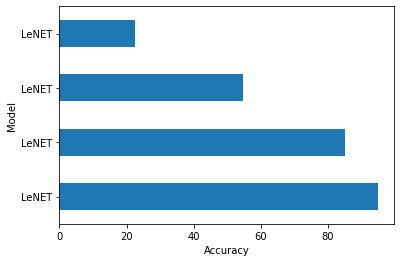

In [150]:
#Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy")
plt.ylabel("Model")